In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
# import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vp
import model_validation.ciff_sam_results as csr
import model_validation.ciff_sam_plots as csp

%load_ext autoreload
%autoreload 2

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model4
ndbs
Fri Nov  5 16:22:51 PDT 2021


# Changes from 4.5.2 to 4.5.3:

- mild->TMREL recovery rate updated from 1/1000 to 1/27.
- x-factor effects: i3=1, i2=3.16, i1=3.16.
- X-factor exposure dependent on wasting state at initialization: sam=0.6, mam=0.5, mild=0.25, tmrel=0.01

Also, Rajan identified the following bug (posted in Slack on Thu 11/4):

> i'm looking at the code now, and i think i am not calculating the x-factor paf correctly. it's being calculated based on an x-factor exposure of 22.155%, which i think must be an old value. the exposure should be dynamically calculated using wasting exposure and thie configurations for their effect on x-factor

So the results here will likely change after the bug is fixed.

# Load results and set global index columns

In [21]:
csr.get_count_data_path('4.5.3')

'/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.3_x_factor_targeted_exposure/ciff_sam/2021_11_02_20_09_56/count_data/'

In [2]:
results = csr.VivariumResults.cleaned_from_model_spec('4.5.3')
results.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'person_time',
 'cause_state_person_time',
 'cause_transition_count']

In [3]:
# No x_factor_effect column in these results since we only used one value
results.wasting_state_person_time

,sex,year,wasting_state,measure,input_draw,scenario,value,x_factor,sq_lns,wasting_treatment,age
0,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat2,covered,covered,early_neonatal
1,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat1,covered,covered,early_neonatal
2,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat2,covered,uncovered,early_neonatal
3,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,cat1,covered,uncovered,early_neonatal
...,...,...,...,...,...,...,...,...,...,...,...
69116,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,18502.676249,cat2,uncovered,covered,2_to_4
69117,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,2490.071184,cat1,uncovered,covered,2_to_4
69118,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,1996.937714,cat2,uncovered,uncovered,2_to_4
69119,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,200.631075,cat1,uncovered,uncovered,2_to_4


In [4]:
# No x_factor_effect column in these results since we only used one value
# vp.set_global_index_columns(vp.INDEX_COLUMNS+['x_factor_effect'])
vp.INDEX_COLUMNS

['input_draw', 'scenario']

# Compute X-factor rate ratios stratified by year and age

In [5]:
wasting_rate_ratio_by_year_age = csr.get_x_factor_wasting_transition_rate_ratio(results, ['year', 'age'])
wasting_rate_ratio_by_year_age

,year,age,transition,from_state,to_state,input_draw,scenario,numerator_x_factor,denominator_x_factor,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,12_to_23_months,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition,29,baseline,cat1,cat2,3.137121,transition_rate,transition_rate,1,rate_ratio
1,2022,12_to_23_months,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition,29,sqlns,cat1,cat2,3.137121,transition_rate,transition_rate,1,rate_ratio
2,2022,12_to_23_months,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition,29,wasting_treatment,cat1,cat2,3.137121,transition_rate,transition_rate,1,rate_ratio
3,2022,12_to_23_months,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition,223,baseline,cat1,cat2,3.128318,transition_rate,transition_rate,1,rate_ratio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,2026,6-11_months,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting,829,wasting_treatment,cat1,cat2,0.966101,transition_rate,transition_rate,1,rate_ratio
3777,2026,6-11_months,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting,946,baseline,cat1,cat2,0.986590,transition_rate,transition_rate,1,rate_ratio
3778,2026,6-11_months,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting,946,sqlns,cat1,cat2,0.992595,transition_rate,transition_rate,1,rate_ratio
3779,2026,6-11_months,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting,946,wasting_treatment,cat1,cat2,0.991104,transition_rate,transition_rate,1,rate_ratio


In [6]:
wasting_rate_ratio_by_year_age.transition.unique()

array(['mild_child_wasting_to_moderate_acute_malnutrition',
       'mild_child_wasting_to_susceptible_to_child_wasting',
       'moderate_acute_malnutrition_to_mild_child_wasting',
       'moderate_acute_malnutrition_to_severe_acute_malnutrition',
       'severe_acute_malnutrition_to_mild_child_wasting',
       'severe_acute_malnutrition_to_moderate_acute_malnutrition',
       'susceptible_to_child_wasting_to_mild_child_wasting'], dtype=object)

In [7]:
wasting_incidence_transitions = (
    'susceptible_to_child_wasting_to_mild_child_wasting',
    'mild_child_wasting_to_moderate_acute_malnutrition',
    'moderate_acute_malnutrition_to_severe_acute_malnutrition',
)

# Plot mild wasting incidence rate ratio over time for each value of X-factor effect

Looks close to 1 as it should.

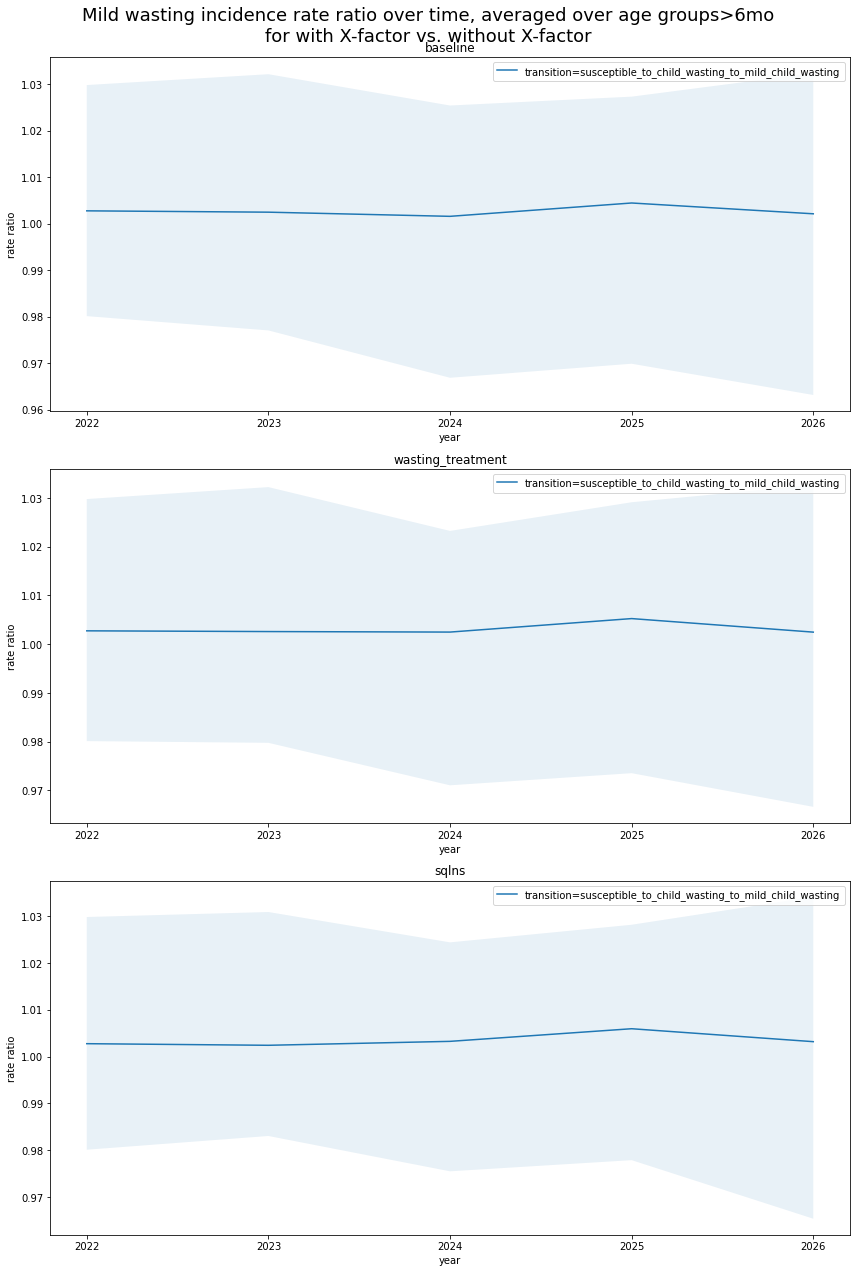

In [9]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    wasting_rate_ratio_by_year_age.query("transition=='susceptible_to_child_wasting_to_mild_child_wasting'"),
    colname='transition',
    ylabel="rate ratio",
    suptitle="Mild wasting incidence rate ratio over time, averaged over age groups>6mo"
        "\nfor with X-factor vs. without X-factor",
    uncertainty=True,
)

# Oops, since I stratified by age, it makes more sense to look at each age group separately

They all look  close to 1 as expected.

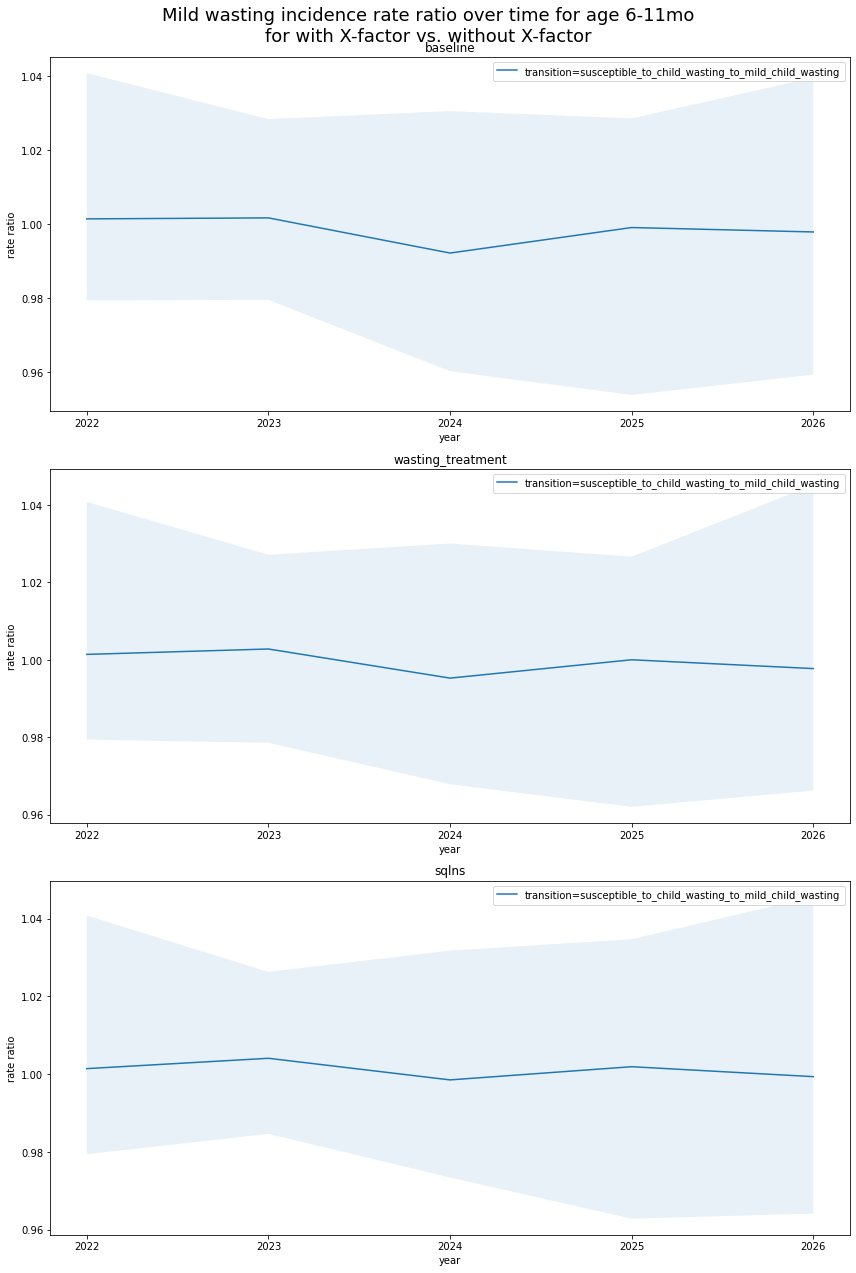

In [10]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    wasting_rate_ratio_by_year_age.query(
        "transition=='susceptible_to_child_wasting_to_mild_child_wasting' and age=='6-11_months'"),
    colname='transition',
    ylabel="rate ratio",
    suptitle="Mild wasting incidence rate ratio over time for age 6-11mo"
        "\nfor with X-factor vs. without X-factor",
    uncertainty=True,
)

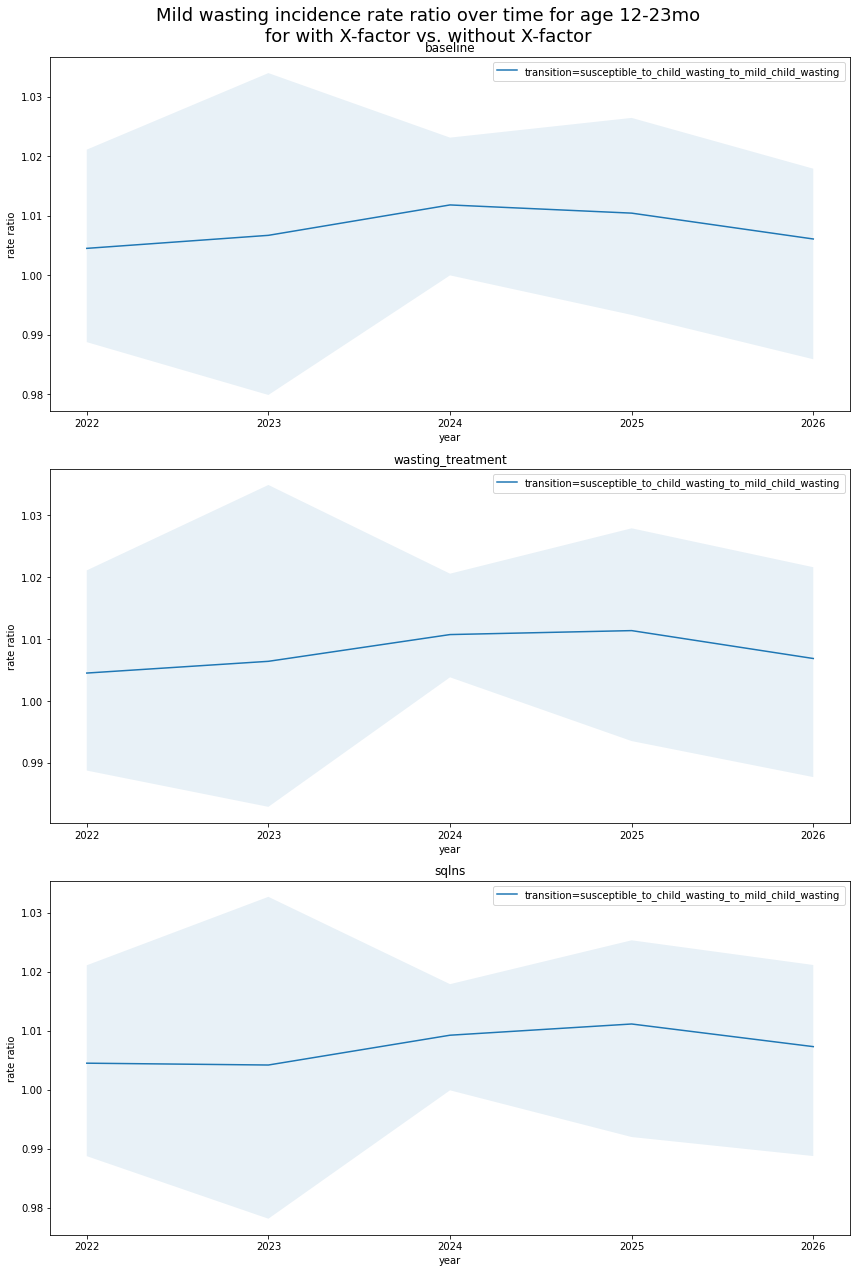

In [11]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    wasting_rate_ratio_by_year_age.query(
        "transition=='susceptible_to_child_wasting_to_mild_child_wasting' and age=='12_to_23_months'"),
    colname='transition',
    ylabel="rate ratio",
    suptitle="Mild wasting incidence rate ratio over time for age 12-23mo"
        "\nfor with X-factor vs. without X-factor",
    uncertainty=True,
)

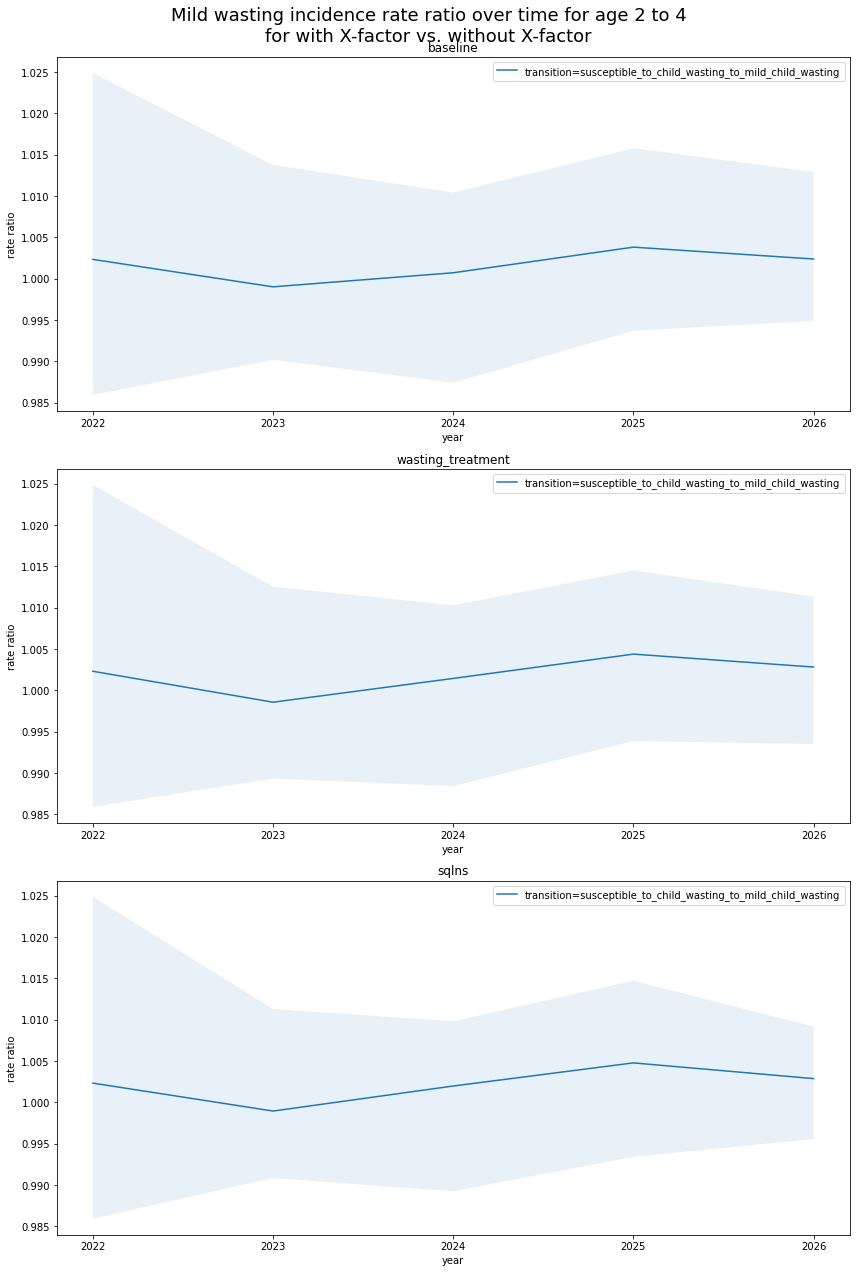

In [12]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    wasting_rate_ratio_by_year_age.query(
        "transition=='susceptible_to_child_wasting_to_mild_child_wasting' and age=='2_to_4'"),
    colname='transition',
    ylabel="rate ratio",
    suptitle="Mild wasting incidence rate ratio over time for age 2 to 4"
        "\nfor with X-factor vs. without X-factor",
    uncertainty=True,
)

# Now compute X-factor rate ratios stratified by year only

In [13]:
wasting_rate_ratio_by_year = csr.get_x_factor_wasting_transition_rate_ratio(results, ['year'])
wasting_rate_ratio_by_year

,year,transition,from_state,to_state,input_draw,scenario,numerator_x_factor,denominator_x_factor,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition,29,baseline,cat1,cat2,3.205643,transition_rate,transition_rate,1,rate_ratio
1,2022,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition,29,sqlns,cat1,cat2,3.205643,transition_rate,transition_rate,1,rate_ratio
2,2022,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition,29,wasting_treatment,cat1,cat2,3.205643,transition_rate,transition_rate,1,rate_ratio
3,2022,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition,223,baseline,cat1,cat2,3.170783,transition_rate,transition_rate,1,rate_ratio
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2026,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting,829,wasting_treatment,cat1,cat2,1.002885,transition_rate,transition_rate,1,rate_ratio
1257,2026,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting,946,baseline,cat1,cat2,0.992739,transition_rate,transition_rate,1,rate_ratio
1258,2026,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting,946,sqlns,cat1,cat2,0.996458,transition_rate,transition_rate,1,rate_ratio
1259,2026,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting,946,wasting_treatment,cat1,cat2,0.996172,transition_rate,transition_rate,1,rate_ratio


# Plot incidence rate ratio over time for each wasting category

Mild incidence rate ratio is close to 1 as above.

Moderate and severe incidence rate ratios are close to 3.2 and 3.25, respectively, as opposed to the expected 3.16. This is probably due to the X-factor PAF miscalculation that Rajan identified in this model run.

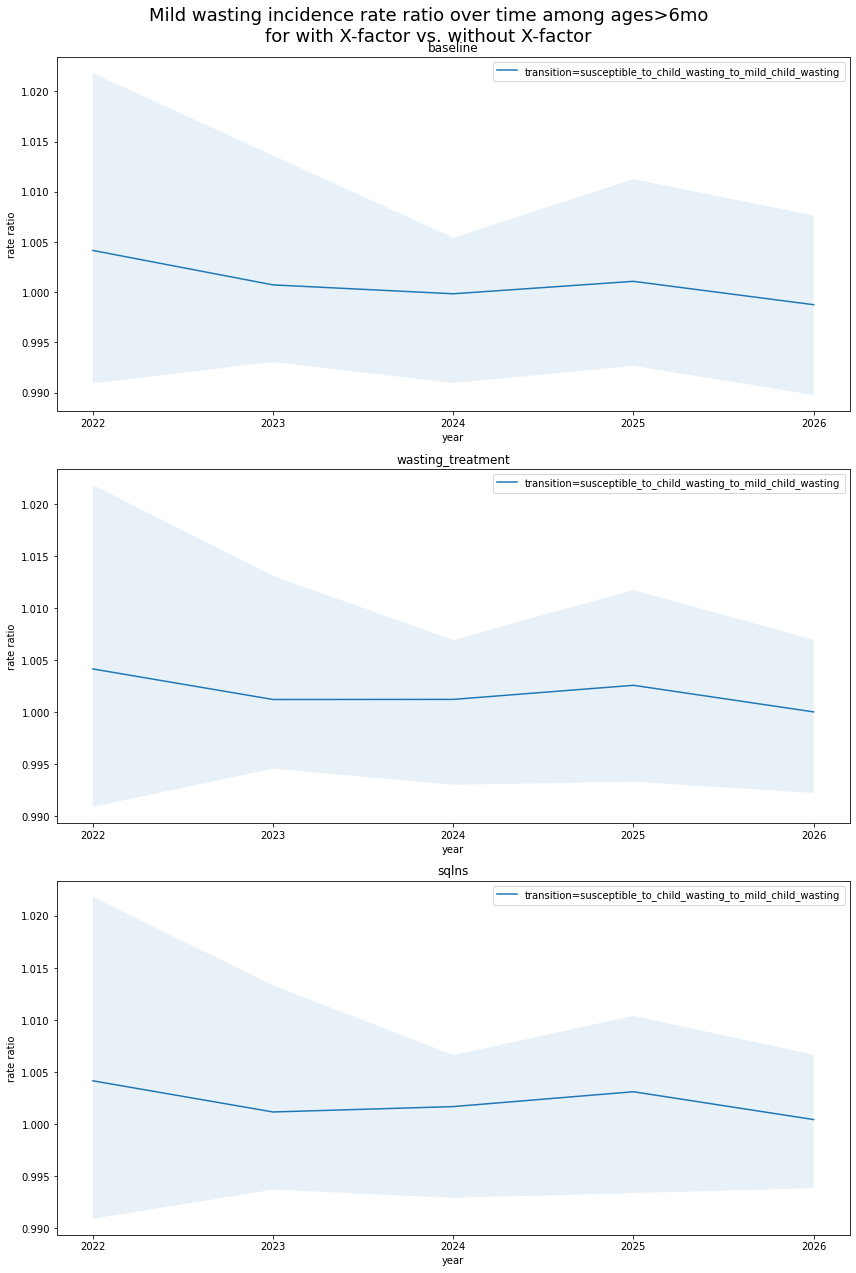

In [14]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    wasting_rate_ratio_by_year.query("transition=='susceptible_to_child_wasting_to_mild_child_wasting'"),
    colname='transition',
    ylabel="rate ratio",
    suptitle="Mild wasting incidence rate ratio over time among ages>6mo"
        "\nfor with X-factor vs. without X-factor",
    uncertainty=True,
)

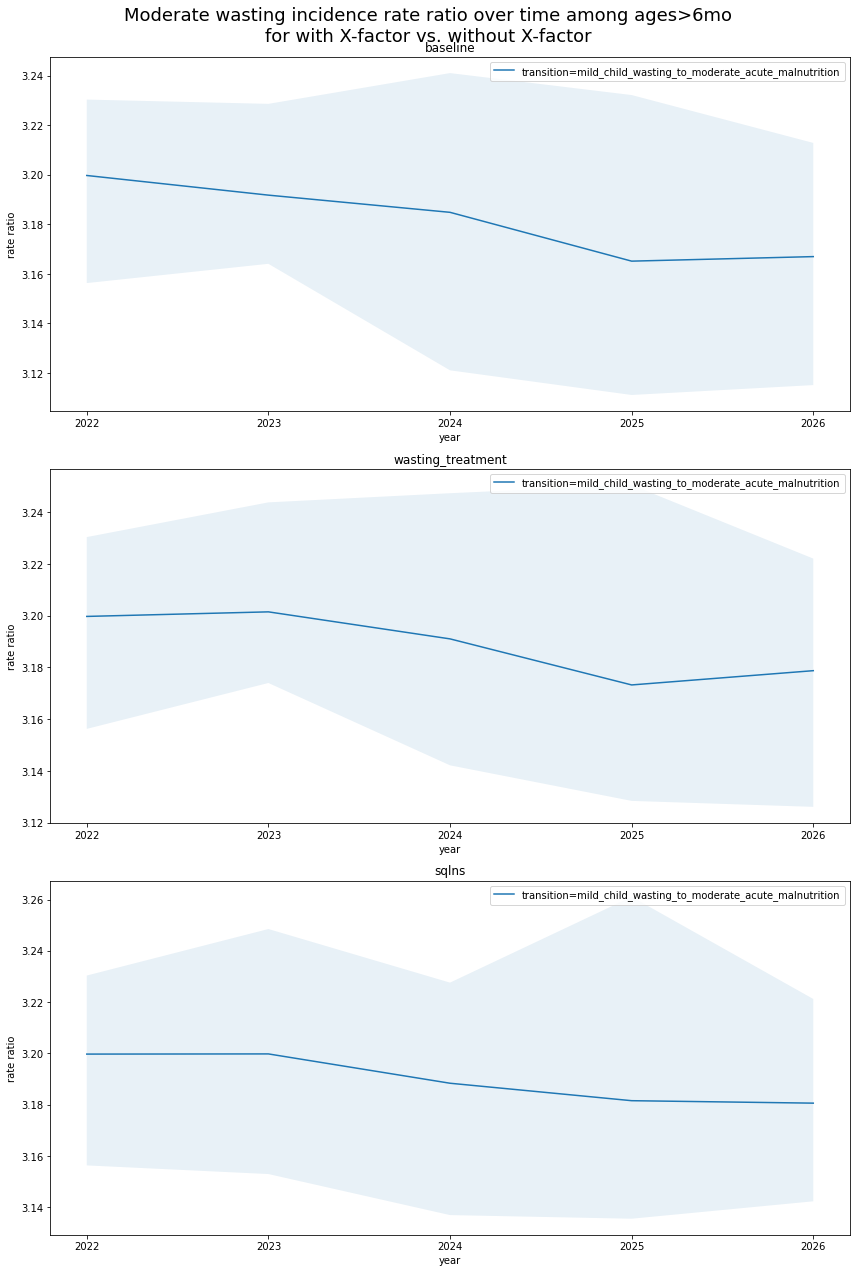

In [15]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    wasting_rate_ratio_by_year.query("transition=='mild_child_wasting_to_moderate_acute_malnutrition'"),
    colname='transition',
    ylabel="rate ratio",
    suptitle="Moderate wasting incidence rate ratio over time among ages>6mo"
        "\nfor with X-factor vs. without X-factor",
    uncertainty=True,
)

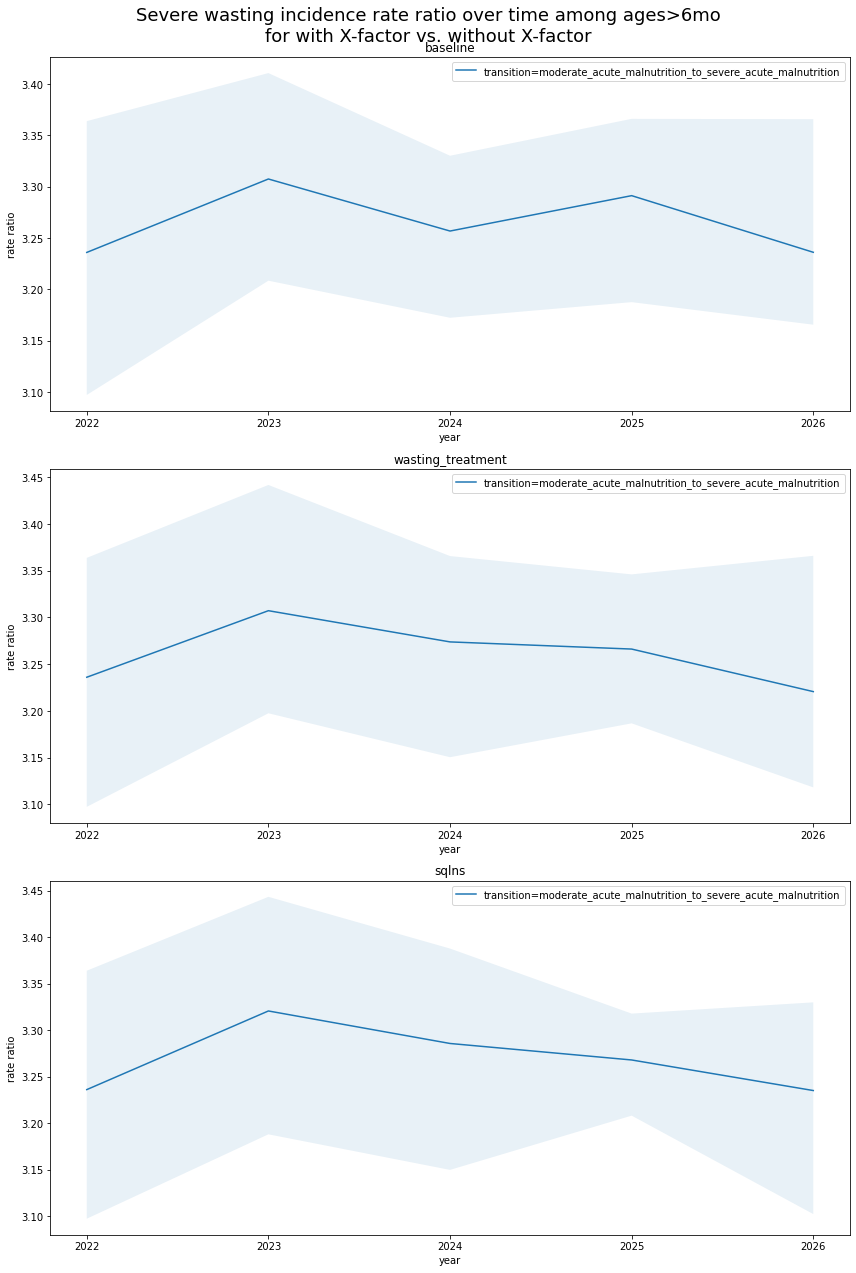

In [16]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    wasting_rate_ratio_by_year.query("transition=='moderate_acute_malnutrition_to_severe_acute_malnutrition'"),
    colname='transition',
    ylabel="rate ratio",
    suptitle="Severe wasting incidence rate ratio over time among ages>6mo"
        "\nfor with X-factor vs. without X-factor",
    uncertainty=True,
)

# Now plot remission rate ratios over time to make sure they're always 1

They're all pretty close to 1, but not as close as in Model 4.5.2. Something to watch out for in the next set of results after the X-factor PAF bug is fixed.

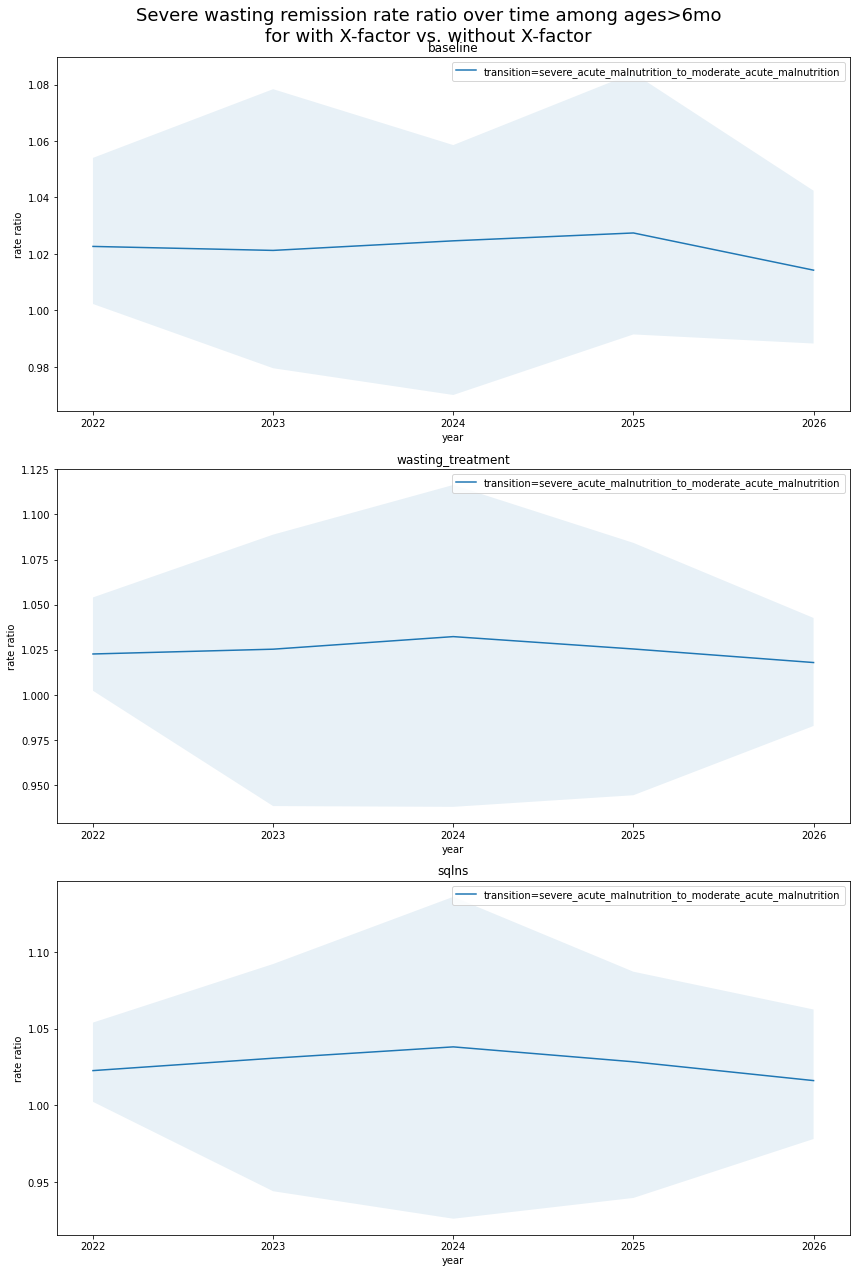

In [17]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    wasting_rate_ratio_by_year.query("transition=='severe_acute_malnutrition_to_moderate_acute_malnutrition'"),
    colname='transition',
    ylabel="rate ratio",
    suptitle="Severe wasting remission rate ratio over time among ages>6mo"
        "\nfor with X-factor vs. without X-factor",
    uncertainty=True,
)

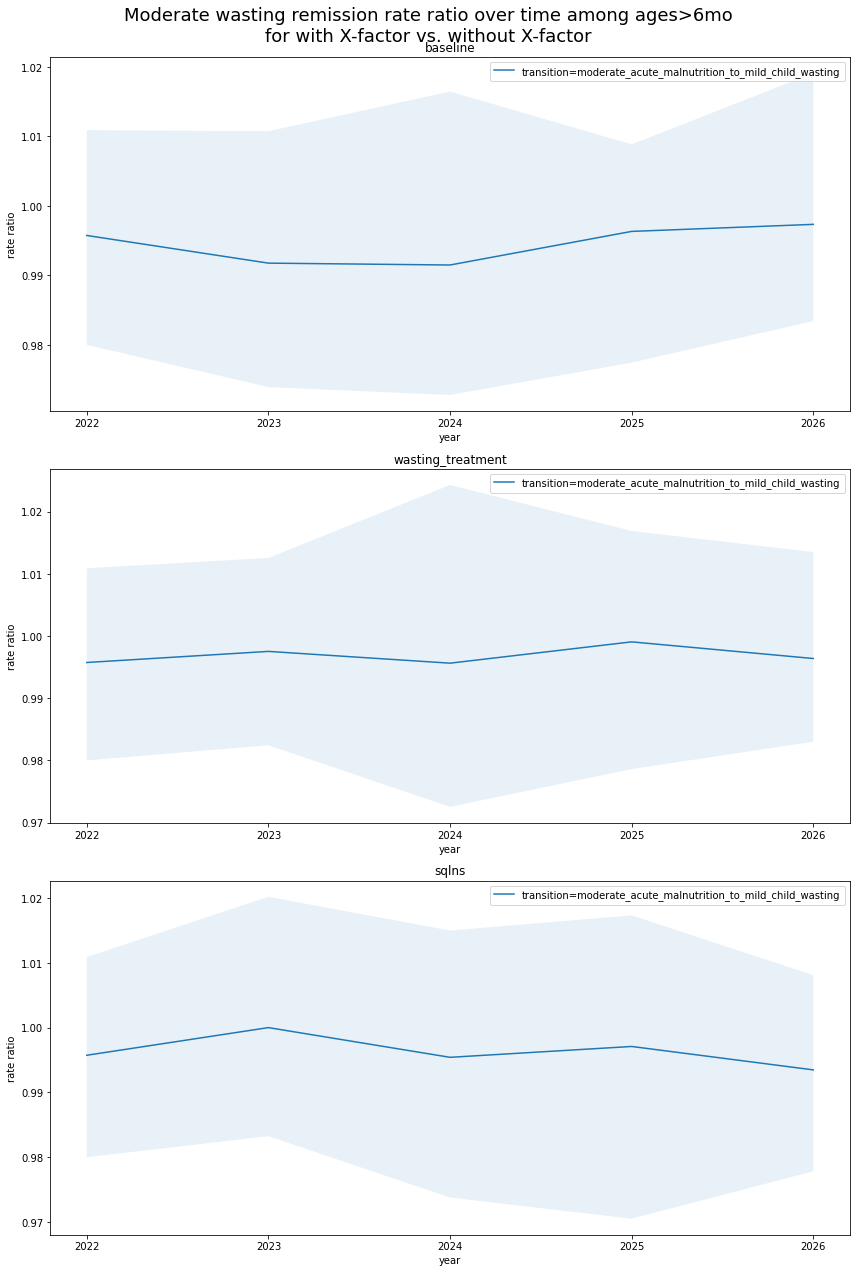

In [18]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    wasting_rate_ratio_by_year.query("transition=='moderate_acute_malnutrition_to_mild_child_wasting'"),
    colname='transition',
    ylabel="rate ratio",
    suptitle="Moderate wasting remission rate ratio over time among ages>6mo"
        "\nfor with X-factor vs. without X-factor",
    uncertainty=True,
)

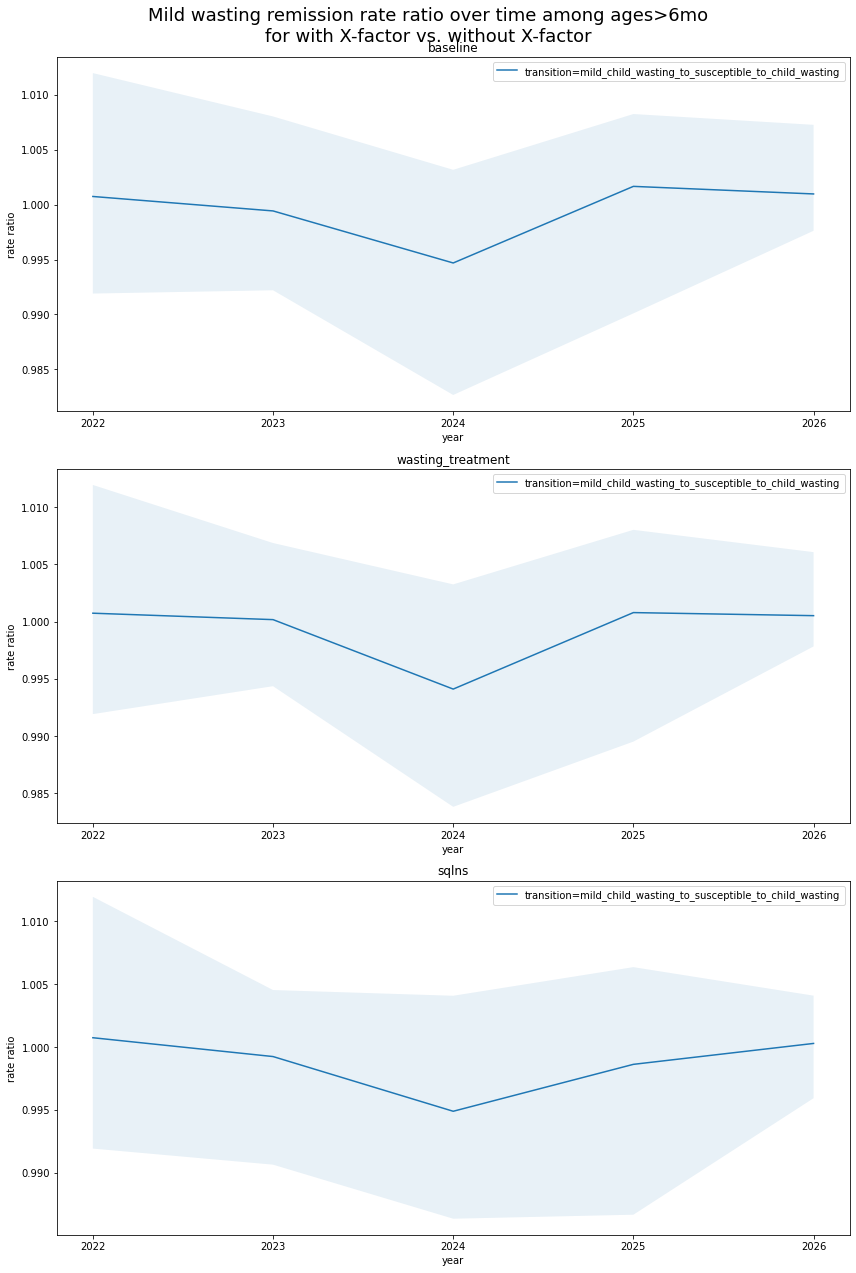

In [19]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    wasting_rate_ratio_by_year.query("transition=='mild_child_wasting_to_susceptible_to_child_wasting'"),
    colname='transition',
    ylabel="rate ratio",
    suptitle="Mild wasting remission rate ratio over time among ages>6mo"
        "\nfor with X-factor vs. without X-factor",
    uncertainty=True,
)

# The sucessful SAM treatment rate ratio should also be 1

It looks a little low.

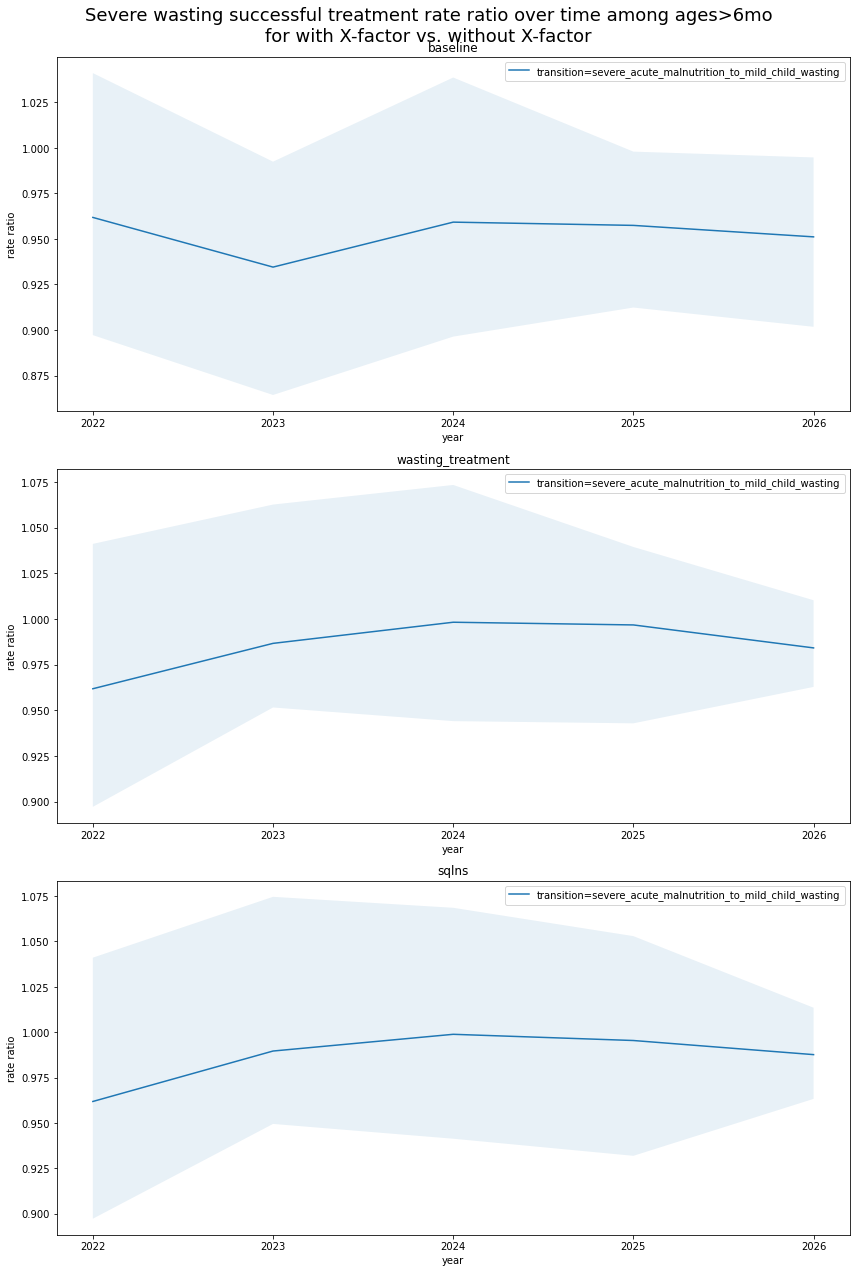

In [20]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    wasting_rate_ratio_by_year.query("transition=='severe_acute_malnutrition_to_mild_child_wasting'"),
    colname='transition',
    ylabel="rate ratio",
    suptitle="Severe wasting successful treatment rate ratio over time among ages>6mo"
        "\nfor with X-factor vs. without X-factor",
    uncertainty=True,
)